<a href="https://colab.research.google.com/github/az6332581/Speech-Analysis/blob/main/speech_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
%cd gdrive/MyDrive/'Colab Notebooks'/
%ls

/content/gdrive/MyDrive/Colab Notebooks
'Collaborative Filter.ipynb'
 data.csv
 data.gsheet
 outputU.csv
'TESS Toronto emotional speech set data'/
 TF-IDF.ipynb
 Untitled
 Untitled0.ipynb
 「YOLOv4_Training_Tutorial.ipynb」的副本


In [5]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [10]:
paths = []
labels = []
for dirname, _, filenames in os.walk('TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [11]:
len(paths)

2800

In [12]:
paths[:5]

['TESS Toronto emotional speech set data/OAF_happy/OAF_base_happy.wav',
 'TESS Toronto emotional speech set data/OAF_happy/OAF_beg_happy.wav',
 'TESS Toronto emotional speech set data/OAF_happy/OAF_back_happy.wav',
 'TESS Toronto emotional speech set data/OAF_happy/OAF_bar_happy.wav',
 'TESS Toronto emotional speech set data/OAF_happy/OAF_bath_happy.wav']

In [13]:
labels[:5]

['happy', 'happy', 'happy', 'happy', 'happy']

In [14]:
## Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,TESS Toronto emotional speech set data/OAF_hap...,happy
1,TESS Toronto emotional speech set data/OAF_hap...,happy
2,TESS Toronto emotional speech set data/OAF_hap...,happy
3,TESS Toronto emotional speech set data/OAF_hap...,happy
4,TESS Toronto emotional speech set data/OAF_hap...,happy


In [13]:
df['label'].value_counts()

angry      600
disgust    600
happy      400
neutral    400
ps         400
fear       200
sad        200
Name: label, dtype: int64

In [15]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveplot(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

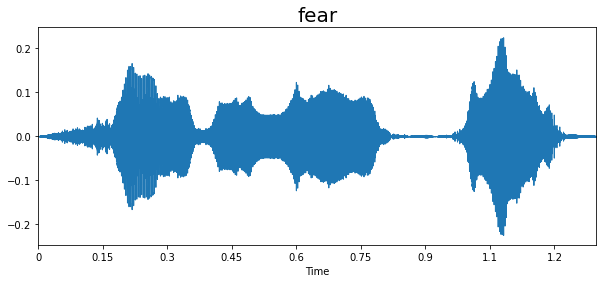

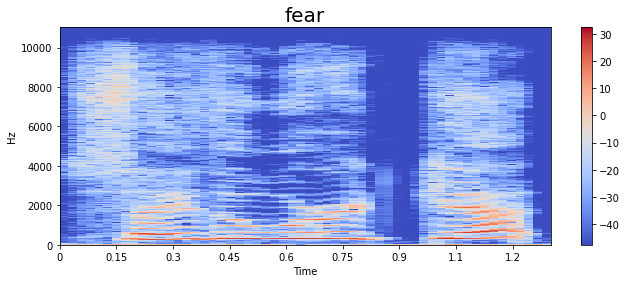

In [15]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

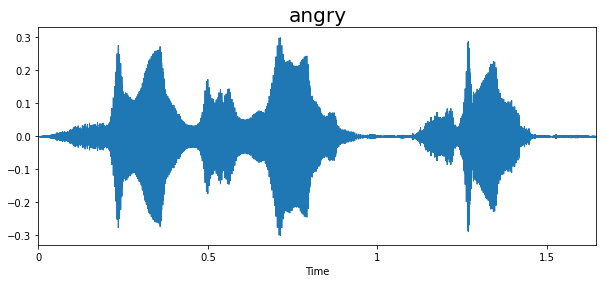

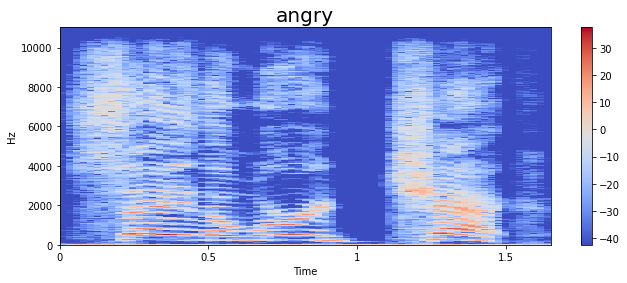

In [16]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [19]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    return mfcc

In [20]:
extract_mfcc(df['speech'][0])

array([-490.03265   ,   81.52517   ,   23.006077  ,    4.5168242 ,
          6.7874827 ,    4.9010463 ,   -4.48615   ,   -1.9166843 ,
        -10.311727  ,    6.105448  ,  -16.377426  ,   -0.51436555,
         -4.624062  ], dtype=float32)

In [36]:
X_mfcc = []
for speech in df['speech']:
  mfcc = extract_mfcc(speech)
  X_mfcc.append(mfcc)

In [67]:
X_mfcc

[array([-490.03265   ,   81.52517   ,   23.006077  ,    4.5168242 ,
           6.7874827 ,    4.9010463 ,   -4.48615   ,   -1.9166843 ,
         -10.311727  ,    6.105448  ,  -16.377426  ,   -0.51436555,
          -4.624062  ], dtype=float32),
 array([-470.24265   ,   99.9165    ,   25.659233  ,    5.4799666 ,
           9.924872  ,   -1.745665  ,  -15.836855  ,    3.5059392 ,
         -18.656569  ,    0.70478225,  -16.86859   ,   -3.4448488 ,
          -2.5551894 ], dtype=float32),
 array([-495.1238   ,  109.69196  ,   11.736398 ,  -12.528988 ,
           7.5828114,   13.42543  ,  -10.353237 ,    2.6756058,
          -9.069315 ,    2.4800327,  -11.954103 ,   -6.1592393,
          -5.2387934], dtype=float32),
 array([-4.69688385e+02,  1.23804596e+02,  2.22379990e+01, -2.68415966e+01,
        -1.26533180e-01,  1.07056170e+01, -5.00803709e+00, -2.07378578e+00,
        -1.58794336e+01,  1.94128168e+00, -1.65148468e+01, -8.93984973e-01,
        -5.35189009e+00], dtype=float32),
 array([-48

In [38]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 13)

In [39]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [40]:
y = y.toarray()

In [41]:
y.shape

(2800, 7)

In [44]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(13,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 7)                

In [109]:
# Train the model
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
35/35 [==============================] - 1s 14ms/step - loss: 3.0076e-05 - accuracy: 1.0000 - val_loss: 21.3786 - val_accuracy: 0.6429
Epoch 2/50
35/35 [==============================] - 0s 11ms/step - loss: 7.4129e-05 - accuracy: 1.0000 - val_loss: 21.4239 - val_accuracy: 0.6429
Epoch 3/50
35/35 [==============================] - 0s 10ms/step - loss: 5.8685e-05 - accuracy: 1.0000 - val_loss: 21.3209 - val_accuracy: 0.6429
Epoch 4/50
35/35 [==============================] - 0s 6ms/step - loss: 1.6440e-05 - accuracy: 1.0000 - val_loss: 21.3803 - val_accuracy: 0.6429
Epoch 5/50
35/35 [==============================] - 0s 6ms/step - loss: 2.8036e-05 - accuracy: 1.0000 - val_loss: 21.4102 - val_accuracy: 0.6429
Epoch 6/50
35/35 [==============================] - 0s 6ms/step - loss: 2.6851e-05 - accuracy: 1.0000 - val_loss: 21.4471 - val_accuracy: 0.6429
Epoch 7/50
35/35 [==============================] - 0s 7ms/step - loss: 7.7412e-05 - accuracy: 1.0000 - val_loss: 21.3155 - val

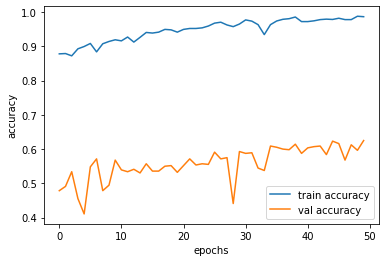

In [47]:
epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

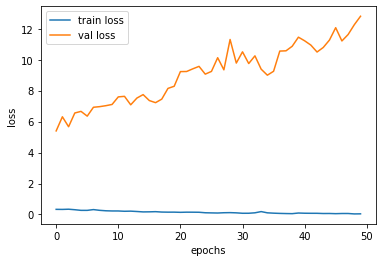

In [48]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

 201.wav                       outputU.csv
 202.wav                      'TESS Toronto emotional speech set data'/
 203.wav                       TF-IDF.ipynb
'Collaborative Filter.ipynb'   Untitled
 data.csv                      Untitled0.ipynb
 data.gsheet                   「YOLOv4_Training_Tutorial.ipynb」的副本


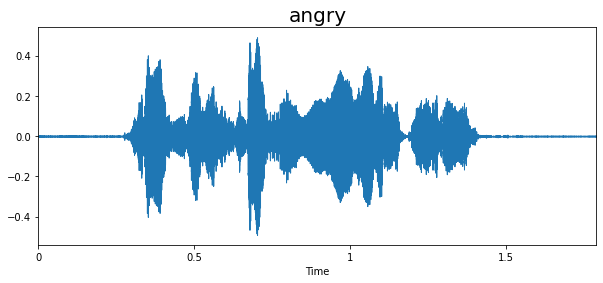

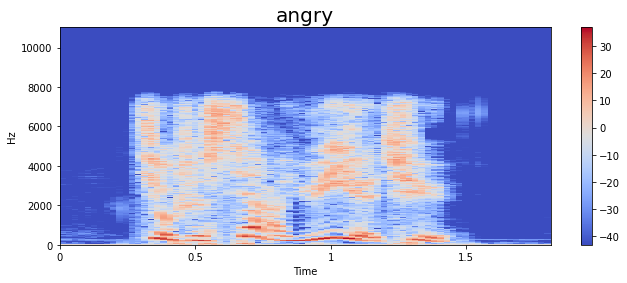

In [89]:
%ls
emotion = 'angry'
data, sampling_rate = librosa.load('201.wav')
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)

In [90]:
mfcc_t = extract_mfcc('201.wav')
mfcc_t.shape
mfcc_t

array([-3.4102554e+02,  6.7583504e+01, -1.3164705e+01,  7.1048744e+01,
       -2.7909851e+01,  1.0676127e+01, -1.3376200e+01,  9.5325727e+00,
       -1.4225213e+01, -6.6599770e+00, -2.6926227e+00, -8.3617458e+00,
        3.3003339e-01], dtype=float32)

In [91]:
mfcc_t = np.expand_dims(mfcc_t, axis=-1)
mfcc_t = np.expand_dims(mfcc_t, axis=0)
mfcc_t.shape

(1, 13, 1)

In [92]:
predictions = model.predict(mfcc_t)
max_index = np.argmax(predictions)
print(max_index)

1/1 [==============================] - 0s 23ms/step
1


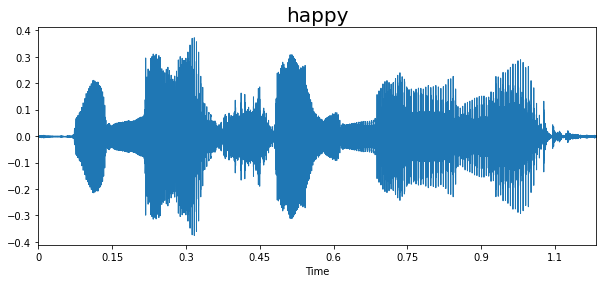

1/1 [==============================] - 0s 45ms/step
2


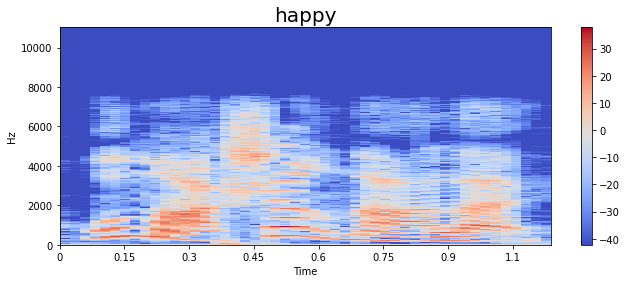

In [110]:
emotion = 'happy'
data, sampling_rate = librosa.load('202.wav')
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
mfcc_t = extract_mfcc('202.wav')
mfcc_t.shape
mfcc_t
mfcc_t = np.expand_dims(mfcc_t, axis=-1)
mfcc_t = np.expand_dims(mfcc_t, axis=0)
mfcc_t.shape
predictions = model.predict(mfcc_t)
max_index = np.argmax(predictions)
print(max_index)

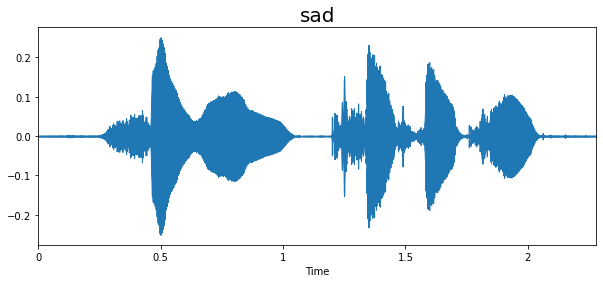

1/1 [==============================] - 0s 31ms/step
1


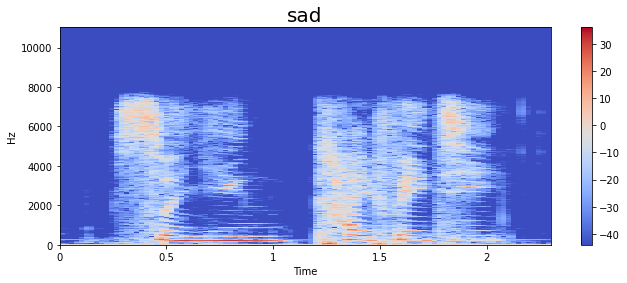

In [111]:
emotion = 'sad'
data, sampling_rate = librosa.load('203.wav')
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
mfcc_t = extract_mfcc('203.wav')
mfcc_t.shape
mfcc_t
mfcc_t = np.expand_dims(mfcc_t, axis=-1)
mfcc_t = np.expand_dims(mfcc_t, axis=0)
mfcc_t.shape
predictions = model.predict(mfcc_t)
max_index = np.argmax(predictions)
print(max_index)